<center>
<h1>DTSA 5511 Final Project - a study of GAN : Face Generation</h1>
<h3> Author: Wenhao Chen<h3>
<h3>Kaggle: <a href="https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data">CelebFaces Attributes (CelebA) Dataset</a></h3>
</center>

<h3>Introduction </h3>
1. Background and Study Goals

A. The Challenge of GAN Training and the Rise of WGAN-GP

Background: Generative Adversarial Networks (GANs) represent a monumental breakthrough in deep learning, demonstrating extraordinary capabilities in image synthesis. However, conventional GANs are notorious for severe training issues, including instability, vanishing gradients, and mode collapse (the failure to generate diverse samples), which have historically limited the quality and variety of synthesized images.

Goal: The primary objective of this study is to leverage the Wasserstein GAN with Gradient Penalty (WGAN-GP) framework to address these limitations. WGAN-GP replaces the traditional discriminator loss with the Wasserstein distance and enforces a gradient penalty regularization term to ensure the Critic satisfies the 1-Lipschitz constraint. This mechanism significantly stabilizes training, leading to the generation of high-fidelity and diverse synthetic facial images.

B. High Fidelity Synthesis using the CelebA Dataset

Background: The research utilizes the Large-scale CelebFaces Attributes (CelebA) dataset, which contains over 200,000 celebrity face images annotated with numerous attributes (such as gender, hair color, and expression). Training on this large, high quality, and richly labeled dataset is crucial for the generator to learn realistic and complex facial feature distributions.

Goal: The immediate goal is to train a generator capable of synthesizing "fake faces" from random noise vectors that are visually indistinguishable from real photographs. This will serve as a strong foundation for exploring advanced attribute control.

2. Extending the Scope: From Generic Fake Faces to Gender-Based Generation

A. Exploring the Semantics of the Latent Space

Background: A key advantage of the WGAN-GP is that its latent space (the input noise vector space) tends to exhibit better continuity and semantic disentanglement. This implies that arithmetic operations on vectors in the latent space can correspond directly to meaningful, predictable changes in the generated images.

Goal: The advanced goal of this research is to explore and manipulate the semantic dimensions within the latent space that correspond to the "gender" attribute labeled in the CelebA dataset.

B. Gender Based Controllable Generation

Ultimate Goal: This study aims to demonstrate that the WGAN-GP acts not merely as an image synthesizer but as a powerful image attribute editing tool. Specifically, by manipulating the latent space, the research seeks to achieve:

Attribute-Specific Generation: Successfully generating fake faces conditioned specifically on the male or female gender attribute.

Attribute Transformation and Interpolation: Showcasing how latent vector arithmetic can be used to smoothly interpolate between two faces of different genders or apply a specific "gender vector" to a neutral face to transform its perceived gender. This success would indicate a deep learned understanding and control over high-level semantic features by the model.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2

In [2]:
print("Physical GPU:", tf.config.list_physical_devices('GPU'))

Physical GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path = "archive-3/"
imagepath = f"{path}img_align_celeba"
z_dim = 100
image_size = 128
batch_size = 64

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
def get_all_images(folder_path):
    return [os.path.join(folder_path, f) 
            for f in os.listdir(folder_path) 
            if f.lower().endswith(".jpg")]

def get_random_image_new(file_list):
    return random.choice(file_list)

def get_random_image(folder_path):
    #files = random.choice(os.listdir(folder_path))
    selected_file = random.choice(os.listdir(folder_path))
    return os.path.join(folder_path, selected_file) 

def imgfolderinfo(file_list):
    sizes = []
    formats = []

    for img_path in file_list:#os.listdir(photo_dir):
        img = Image.open(img_path)
        sizes.append(img.size)
        formats.append(img.format)

    sizes = np.array(sizes)

    print("Total images:", len(sizes))
    print("Mean size:", sizes.mean(axis=0))
    print("Min size:", sizes.min(axis=0))
    print("Max size:", sizes.max(axis=0))
    return sizes

def plot_25_random_images(file_list, title):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10)) 
    fig.suptitle(title, fontsize=16)
    selected = random.sample(file_list, 25)
    idx = 0
    for i in range(5):
        for j in range(5):
            image_path = selected[idx]
            idx += 1
            image = cv2.imread(image_path)
            
            axes[i, j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[i, j].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()





<h3>EDA</h3>

The CelebA (Large-scale CelebFaces Attributes) dataset is a cornerstone for face generation research. A thorough EDA is crucial for preparing the data for a WGAN-GP, as the model's success hinges on understanding the input distribution.

| Attribute      | Detail                                | Relevance to WGAN-GP                                                                 |
|----------------|---------------------------------------|---------------------------------------------------------------------------------------|
| Size           | 202,599 images                   | Provides a vast, diverse distribution, reducing the risk of mode collapse.            |
| Image Format   | JPG shape:178. 218                                  | Standard format; requires loading and pre-processing (resizing, normalization).       |
| Annotations    | 40 binary attribute labels per image  | Used for conditional generation (e.g., gender, hair color) and potential evaluation metrics. |
| Bounding Boxes | Face location and five facial landmarks | Used for cropping and alignment, which is vital for training stability.               |


The raw CelebA data requires specific steps to ensure optimal WGAN-GP training:

Cropping and Alignment: Since faces are not perfectly centered, the provided bounding box information is essential. Images are typically cropped around the face area and resized to a consistent dimension (e.g., 64×64, 128×128, or 256×256).

Normalization: Pixel values (0-255) must be normalized to a range suitable for the hyperbolic tangent (tanh) activation function often used in the final layer of the Generator. This range is usually [-1, 1].

$$Normalized Pixel=\Big( \frac{pixelValue}{127.5} \Big)−1$$
Data Augmentation: While GANs often rely on the raw distribution, minor augmentations (e.g., small shifts, horizontal flips) can sometimes be applied to increase robustness, provided they don't destroy facial symmetry.

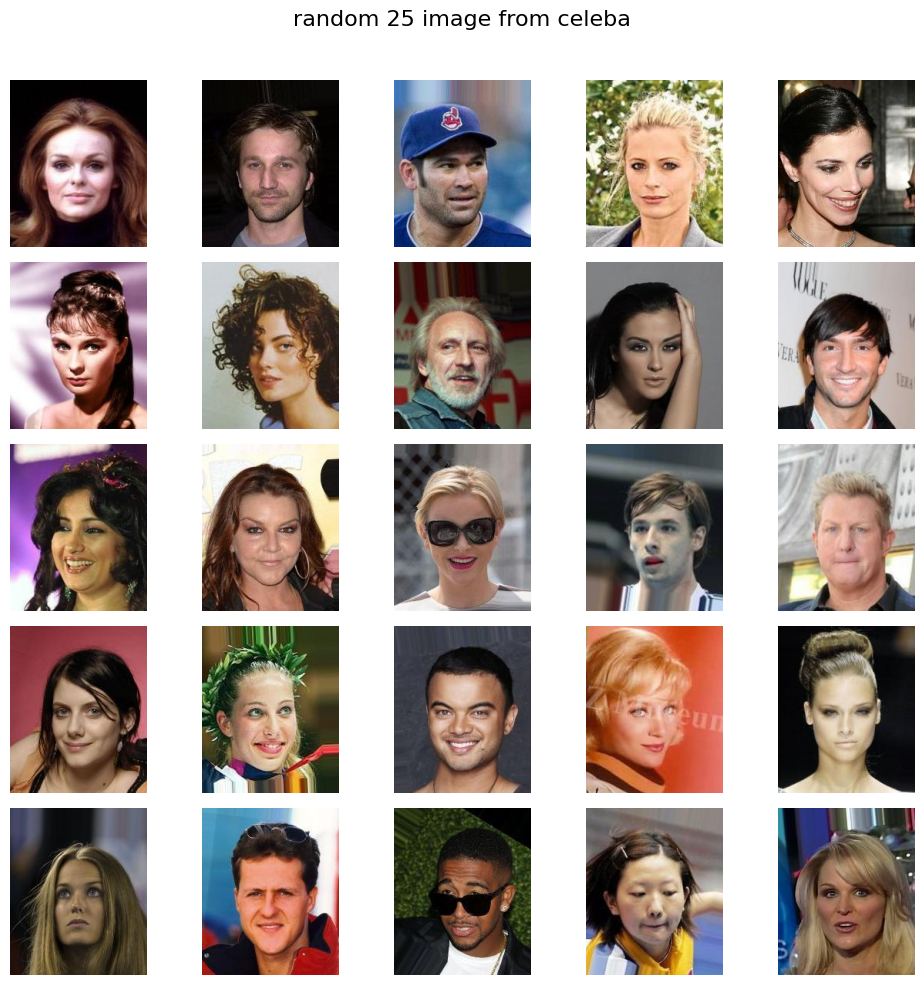

Total images: 202599
Mean size: [178. 218.]
Min size: [178 218]
Max size: [178 218]


In [7]:
file_list = get_all_images(f"{imagepath}/img_align_celeba")

plot_25_random_images(file_list, f"random 25 image from celeba")
#sizes = imgfolderinfo(file_list)

In [8]:
sizes = imgfolderinfo(file_list)

Total images: 202599
Mean size: [178. 218.]
Min size: [178 218]
Max size: [178 218]


Since the study focuses on gender-based generation, an EDA on this specific attribute is necessary.
| Attribute | Value  | Count (Approx.) | Percentage (Approx.) | Implication for Training                                                   |
|-----------|--------|-----------------|----------------------|----------------------------------------------------------------------------|
| Gender    | Male   | ≈83,000         | ≈41.7%                 | Minority class. May require careful balancing or strategic sampling for conditional training. |
| Gender    | Female | ≈116,000        | ≈58.3%                 | Majority class. Model may naturally gravitate toward generating female faces. |


Class Imbalance: The CelebA dataset exhibits a notable imbalance in gender, with more female images than male images.

Risk: If trained unconditionally, the Generator might produce more female-looking faces. If trained conditionally, the Generator might take longer to achieve high quality for the under-represented male class.

Mitigation: For conditional WGAN-GP, techniques like equal sampling (where an equal number of male and female images are sampled per batch) are often employed to manage this imbalance.


Before training, a qualitative check confirms the diversity and challenges:

Variability: Images vary widely in pose, background, age, lighting, and accessories (glasses, hats).

Challenge: The WGAN-GP must learn to disentangle these highly correlated features (e.g., lighting and age) to produce controllable and realistic outputs.

Resolution: The final selected training resolution will dictate the complexity and depth of the Generator/Critic architecture. Higher resolution requires deeper networks and significantly more VRAM/time.


The EDA informs the data loading process for the GAN:

Input to Critic (Real Data): Batches of normalized and aligned images from the CelebA dataset.

Input to Generator (Noise): A latent vector z (e.g., a 128-dimensional vector sampled from a standard normal distribution $N(0,1)$).

Conditional Input (for gender control): If training conditionally, the one-hot encoded gender label (e.g., [1,0] for male, [0,1] for female) is concatenated with the noise vector z or integrated into the network layers (via Conditional Batch Normalization).

None


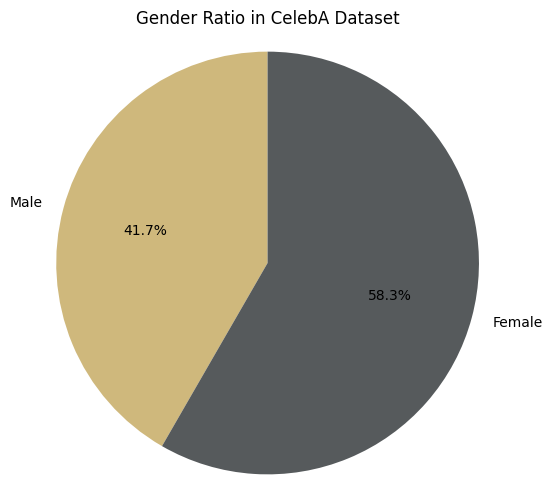

In [13]:
attr_file = f"{path}list_attr_celeba.csv"
df = pd.read_csv(attr_file)
gender_counts = df['Male'].value_counts()

labels = ['Male', 'Female']
sizes = [gender_counts[1], gender_counts[-1]]


plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#CFB87C','#565A5C'])
plt.title("Gender Ratio in CelebA Dataset")
plt.axis('equal') 
plt.show()

In [6]:

def load_celeba(datapath, batch_size=64, image_size=image_size):

    path = os.path.join(datapath, 'img_align_celeba')
    print(path)
    dataset = tf.data.Dataset.list_files(path + '/*.jpg')
    def preprocess(file_path):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [image_size, image_size])
        image = (tf.cast(image, tf.float32) / 127.5) - 1.0
        return image
    
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(10000).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


def prepare_data_iterator(dataset, batch_size):

    dataset = dataset.cache().shuffle(1000).batch(batch_size).repeat()
    
    iterator = iter(dataset)
    return iterator



<h3>model impelement</h3>

The Wasserstein GAN with Gradient Penalty (WGAN-GP) is an advancement over the original GAN and the first WGAN, designed to provide more stable training and avoid mode collapse.

A. Core Concept: Wasserstein Distance (Earth Mover's Distance)

The Problem with Standard GAN: The original GAN uses the Jensen-Shannon Divergence (JSD), which is ill-suited for comparing distributions that are highly separated (non-overlapping), a common occurrence in high-dimensional image data. When the JSD saturates, the gradients disappear, and the model stops learning.

WGAN Solution: WGAN uses the Wasserstein-1 Distance (also known as Earth Mover's Distance). This distance measures the minimum "cost" to transport mass from one probability distribution ($P_r$, real data) to match the other ($P_g$, generated data).

Advantage: Unlike JSD, the Wasserstein distance provides a meaningful, continuous gradient even when the distributions are far apart. This ensures the Critic (renamed from Discriminator) always gives useful feedback to the Generator.

B. The Lipschitz Constraint and the Gradient Penalty (GP)

The definition of the Wasserstein distance requires the Critic function f (often denoted D in WGAN literature) to be K-Lipschitz continuous (usually K=1). This means that the slope of the Critic's function is bounded, preventing it from having sudden, steep changes.

The WGAN Failure (Weight Clipping): The original WGAN enforced the Lipschitz constraint by clipping the Critic's weights to a small range (e.g., [−0.01,0.01]). This led to undesirable behavior, such as limiting the model's capacity and causing pathological gradient issues.

WGAN-GP Solution (Gradient Penalty): WGAN-GP replaces weight clipping with a Gradient Penalty (λ) term added to the Critic's loss function. This term penalizes the Critic if the norm of its gradients with respect to its input is far from 1.

The WGAN-GP Critic loss function is:
   $$
    L_D = \mathbb{E}_{\tilde{x} \sim P_g}[D(\tilde{x})] 
      - \mathbb{E}_{x \sim P_r}[D(x)] 
      + \lambda \, \mathbb{E}_{\hat{x} \sim P_{\hat{x}}} 
      \Big[ \big(\lVert \nabla_{\hat{x}} D(\hat{x}) \rVert_2 - 1 \big)^2 \Big]
$$

Where:

The first two terms are the Wasserstein Distance approximation (Critic tries to maximize this).

$\tilde{x}$ are fake samples, x are real samples.

λ is the penalty coefficient (in my model λ=10).

$\hat{x}$ are samples taken along straight lines between the real (x) and fake ( $\tilde{x}$) data.



Generator:
Deep Convolutional GAN (DCGAN)
| Layer Operation   | Input Shape (Example: 256x256 target) | Output Shape   | Description and WGAN-GP Relevance                                                                 |
|-------------------|---------------------------------------|----------------|---------------------------------------------------------------------------------------------------|
| Input             | (z_dim,) (e.g., 128)                 | (128,)         | Latent noise vector z.                                                                             |
| Dense             | (128,)                               | (8192,)        | Transforms the noise into the necessary volume for the first convolutional block.                 |
| Reshape           | (8192,)                              | (4,4,512)      | Creates a 4×4 initial feature map with 512 channels (deepest layer).                              |
| Conv2DTranspose   | (4,4,512)                            | (4,4,512)      | No stride, just transforms feature maps.                                                          |
| Conv2DTranspose   | →                                    | (8,8,256)      | Stride 2: Upsamples to 8×8.                                                                       |
| Conv2DTranspose   | →                                    | (16,16,128)    | Stride 2: Upsamples to 16×16.                                                                     |
| Conv2DTranspose   | →                                    | (32,32,64)     | Stride 2: Upsamples to 32×32.                                                                     |
| Conv2DTranspose   | →                                    | (64,64,32)     | Stride 2: Upsamples to 64×64.                                                                     |
| Conv2DTranspose   | →                                    | (128,128,3)    | Stride 2: Final upsampling (likely to 128×128 if image size is 256) and output channels reduced to 3 (RGB). |
| Activation        | (Final layer)                        | tanh           | Standard for GANs to map output pixels to the normalized range of [−1,1].                         |
| Normalization     | (Internal)                           | BatchNormalization | Stabilizes training and speeds convergence.                                                   |
| Initializer       | All layers                           | RandomNormal(stddev=0.02) | Standard practice in DCGAN/WGAN to use a zero-mean, low-variance weight initialization. |


Critic:

| Layer Operation | Input Shape            | Output Shape (Example: 256x256 target) | Description and WGAN-GP Relevance                                                                 |
|-----------------|------------------------|----------------------------------------|---------------------------------------------------------------------------------------------------|
| Input           | (image_size,image_size,3) | (256,256,3)                           | Input image (real or fake).                                                                       |
| Conv2D          | →                      | (128,128,32)                           | Stride 2: Downsamples to 128×128.                                                                 |
| Conv2D          | →                      | (64,64,64)                             | Stride 2: Downsamples to 64×64.                                                                   |
| Conv2D          | →                      | (32,32,128)                            | Stride 2: Downsamples to 32×32.                                                                   |
| Conv2D          | →                      | (16,16,256)                            | Stride 2: Downsamples to 16×16.                                                                   |
| Conv2D          | →                      | (8,8,512)                              | Stride 2: Downsamples to 8×8.                                                                     |
| Conv2D          | →                      | (8,8,1)                                | No stride, reduces channels to 1.                                                                 |
| Flatten         | (8,8,1)                | (64,)                                  | Flattens the feature map.                                                                         |
| Output          | (64,)                  | (1,)                                   | Final layer is a linear output (no activation like sigmoid/softmax), essential for WGAN-GP to output a raw score/distance estimate. |
| Normalization   | (Internal)             | LayerNormalization                      | Crucial WGAN-GP change. WGAN-GP commonly replaces BatchNormalization with Layer Normalization (or no normalization) in the Critic to avoid introducing spurious correlations that can violate the Lipschitz constraint. |
| Activation      | (Internal)             | LeakyReLU                              | Standard non-linearity for Critics/Discriminators.                                                |


In [7]:


def make_generator(z_dim=128):
    input = layers.Input(shape=(z_dim,))

    x = layers.Dense(4*4*256, use_bias=False)(input)
    x = layers.Reshape((4, 4, 256))(x)
    """
    x = layers.Conv2DTranspose(1024, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    """
    x = layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    
    output = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=input, outputs=output, name = "generator")
    return model



'''
    model.add(layers.Dense(4*4*1024, )
    model.add(layers.Reshape((4, 4, 1024)))
    
    model.add(layers.Conv2DTranspose(512, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, 4, strides=2, padding='same')) # Added Filter change
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(3, 4, strides=1, padding='same', activation='tanh'))
    return model

'''
def make_critic():

    input = layers.Input(shape=(image_size, image_size, 3))
    
    """
    x = layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)
    """
    
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(1024, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = layers.Flatten()(x)
 
    
    output = layers.Dense(1)(x)
    
    model = Model(inputs=input, outputs=output, name = "critic")
    return model

    """
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(image_size, image_size, 3)))

    model.add(layers.Conv2D(32, 4, strides=2, padding='same')) 
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2D(64, 4, strides=2, padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 4, strides=2, padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(256, 4, strides=2, padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(512, 4, strides=2, padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU(0.2))
              
    model.add(layers.Conv2D(1, 4, strides=1, padding="valid"))
    model.add(layers.Flatten())  
    #model.add(Dense(1, activation='sigmoid'))
    return model
"""
"""
def make_generator(z_dim=128):
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, input_shape=(z_dim,)))
    model.add(layers.Reshape((4, 4, 1024)))
    
    model.add(layers.Conv2DTranspose(512, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, 4, strides=2, padding='same')) # Added Filter change
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(3, 4, strides=1, padding='same', activation='tanh'))
    return model


def make_critic():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(image_size, image_size, 3)))

    model.add(layers.Conv2D(32, 4, strides=2, padding='same')) 
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2D(64, 4, strides=2, padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 4, strides=2, padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(256, 4, strides=2, padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(512, 4, strides=2, padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU(0.2))
              
    model.add(layers.Conv2D(1, 4, strides=1, padding="valid"))
    model.add(layers.Flatten())  
    #model.add(Dense(1, activation='sigmoid'))
    return model
    """

'\ndef make_generator(z_dim=128):\n    model = tf.keras.Sequential()\n    model.add(layers.Dense(4*4*1024, input_shape=(z_dim,)))\n    model.add(layers.Reshape((4, 4, 1024)))\n    \n    model.add(layers.Conv2DTranspose(512, 4, strides=2, padding=\'same\'))\n    model.add(layers.BatchNormalization())\n    model.add(layers.ReLU())\n\n    model.add(layers.Conv2DTranspose(256, 4, strides=2, padding=\'same\'))\n    model.add(layers.BatchNormalization())\n    model.add(layers.ReLU())\n\n    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding=\'same\'))\n    model.add(layers.BatchNormalization())\n    model.add(layers.ReLU())\n\n    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding=\'same\'))\n    model.add(layers.BatchNormalization())\n    model.add(layers.ReLU())\n\n    model.add(layers.Conv2DTranspose(32, 4, strides=2, padding=\'same\')) # Added Filter change\n    model.add(layers.BatchNormalization())\n    model.add(layers.ReLU())\n    \n    model.add(layers.Conv2DTranspo

In [10]:
"""
class ResBlockDown(tf.keras.layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.filters = filters
        self.conv1 = layers.Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv2 = layers.Conv2D(filters, 3, padding="same", use_bias=False)
        self.shortcut_conv = layers.Conv2D(filters, 1, use_bias=False)
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()

    def call(self, x):
        shortcut = self.shortcut_conv(x)
        shortcut = tf.nn.avg_pool(shortcut, ksize=2, strides=2, padding='SAME')

        x = self.conv1(x)
        x = self.norm1(x)
        x = tf.nn.leaky_relu(x, 0.2)

        x = self.conv2(x)
        x = self.norm2(x)
        x = tf.nn.leaky_relu(x, 0.2)

        x = tf.nn.avg_pool(x, ksize=2, strides=2, padding='SAME')

        return x + shortcut

class ResBlockUp(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

        # 主分支
        self.conv1 = layers.Conv2D(filters, 3, padding="same", use_bias=False)
        self.bn1   = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, 3, padding="same", use_bias=False)
        self.bn2   = layers.BatchNormalization()

        # shortcut 分支
        self.shortcut_conv = layers.Conv2D(filters, 1, padding="same", use_bias=False)

    def call(self, x, training=False):
        # 上采样：用 resize 避免棋盘格
        h = tf.shape(x)[1]
        w = tf.shape(x)[2]
        up = tf.image.resize(x, (h * 2, w * 2), method="nearest")#bilinear"

        # shortcut：只做 1×1 卷积
        shortcut = self.shortcut_conv(up)
        
        #shortcut = tf.nn.relu(shortcut)
        # 主分支
        y = self.conv1(up)
        y = self.bn1(y, training=training)
        y = tf.nn.relu(y)

        y = self.conv2(y)
        y = self.bn2(y, training=training)
        y = tf.nn.relu(y)

        return y + shortcut


def make_generator(z_dim=128):
    z = layers.Input(shape=(z_dim,))
    
    x = layers.Dense(4*4*128)(z)
    x = layers.Reshape((4, 4, 128))(x)

    #x = ResBlockUp(512)(x)    # 8x8
    x = ResBlockUp(256)(x)    # 16x16
    x = ResBlockUp(128)(x)    # 32x32
    x = ResBlockUp(64)(x)     # 64x64
    x = ResBlockUp(32)(x)     # 128x128
    #x = ResBlockUp(16)(x)
    #x = ResBlockUp(16)(x)
    out = layers.Conv2D(3, 3, padding="same", activation="tanh")(x)

    return tf.keras.Model(z, out, name="generator")

def make_critic():
    img = layers.Input(shape=(image_size, image_size, 3))
    
    #x = ResBlockDown(16)(img)
    x = ResBlockDown(32)(img)
    x = ResBlockDown(64)(x)    # 64x64
    x = ResBlockDown(128)(x)     # 32x32
    x = ResBlockDown(256)(x)     # 16x16
    #x = ResBlockDown(512)(x)     # 8x8
    #x = ResBlockDown(1024)(x)    # 4x4

    x = layers.Flatten()(x)
    out = layers.Dense(1)(x)

    return tf.keras.Model(img, out, name="critic")
"""

'\nclass ResBlockDown(tf.keras.layers.Layer):\n    def __init__(self, filters):\n        super().__init__()\n        self.filters = filters\n        self.conv1 = layers.Conv2D(filters, 3, padding="same", use_bias=False)\n        self.conv2 = layers.Conv2D(filters, 3, padding="same", use_bias=False)\n        self.shortcut_conv = layers.Conv2D(filters, 1, use_bias=False)\n        self.norm1 = layers.LayerNormalization()\n        self.norm2 = layers.LayerNormalization()\n\n    def call(self, x):\n        shortcut = self.shortcut_conv(x)\n        shortcut = tf.nn.avg_pool(shortcut, ksize=2, strides=2, padding=\'SAME\')\n\n        x = self.conv1(x)\n        x = self.norm1(x)\n        x = tf.nn.leaky_relu(x, 0.2)\n\n        x = self.conv2(x)\n        x = self.norm2(x)\n        x = tf.nn.leaky_relu(x, 0.2)\n\n        x = tf.nn.avg_pool(x, ksize=2, strides=2, padding=\'SAME\')\n\n        return x + shortcut\n\nclass ResBlockUp(tf.keras.layers.Layer):\n    def __init__(self, filters, **kwargs):

In [11]:
"""
z = tf.random.normal([1, 128])
x = layers.Dense(4*4*1024)(z)
x = tf.reshape(x, (1, 4, 4, 1024))

for i in range(6):
    x = residual_block(x, 1024)
    print("after block", i, tf.reduce_mean(x), tf.reduce_min(x), tf.reduce_max(x))
    """

'\nz = tf.random.normal([1, 128])\nx = layers.Dense(4*4*1024)(z)\nx = tf.reshape(x, (1, 4, 4, 1024))\n\nfor i in range(6):\n    x = residual_block(x, 1024)\n    print("after block", i, tf.reduce_mean(x), tf.reduce_min(x), tf.reduce_max(x))\n    '

In [12]:

def gradient_penalty(critic, real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real + (1 - alpha) * fake

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = gp_tape.gradient(pred, [interpolated])[0]
    grads = tf.reshape(grads, [batch_size, -1])
    norms = tf.norm(grads, axis=1)
    gp = tf.reduce_mean((norms - 1.0) ** 2)
    return gp


In [15]:
class WGAN_GP(tf.keras.Model):
    def __init__(self, generator, critic,
                 z_dim, n_critic=5, gp_weight=10.0, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.critic = critic
        self.z_dim = z_dim
        self.n_critic = n_critic
        self.gp_weight = gp_weight

        self.c_loss_tracker = tf.keras.metrics.Mean(name="c_loss")
        self.g_loss_tracker = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_tracker, self.g_loss_tracker]

    def set_learning_rate(new_lr):

        self.g_optimizer.learning_rate.assign(new_lr)
        self.c_optimizer.learning_rate.assign(new_lr)
        
    def compile(self, g_optimizer , c_optimizer):
        super().compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer

    def gradient_penalty(self, real_images, fake_images):
        
        batch_size = tf.shape(real_images)[0]
        epsilon = tf.random.uniform(
            [batch_size, 1, 1, 1], 0.0, 1.0
        )
        mixed = epsilon * tf.cast(real_images, tf.float32) + \
                (1.0 - epsilon) * fake_images

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(mixed)
            mixed_pred = self.critic(mixed, training=True)

        grads = gp_tape.gradient(mixed_pred, mixed)
        grads = tf.reshape(grads, [batch_size, -1])
        grad_norms = tf.norm(grads, axis=1)              
        gp = tf.reduce_mean(tf.square(grad_norms - 1.0)) 
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, (tuple, list)):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        for _ in range(self.n_critic):
            noise = tf.random.normal([batch_size, self.z_dim])

            with tf.GradientTape() as d_tape:
                fake_images = self.generator(noise, training=True)
                #print(fake_images.shape)
                fake_pred = self.critic(fake_images, training=True)
                real_pred = self.critic(real_images, training=True)

                gp = self.gradient_penalty(real_images, fake_images)

                epsilon = 0.001 
                drift_loss = epsilon * tf.reduce_mean(tf.square(real_pred))

 
                c_loss = (tf.reduce_mean(fake_pred)
                          - tf.reduce_mean(real_pred)
                          + self.gp_weight * gp + drift_loss)

            d_grads = d_tape.gradient(c_loss,
                                      self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(d_grads, self.critic.trainable_variables)
            )

        
        noise = tf.random.normal([batch_size, self.z_dim])
        with tf.GradientTape() as g_tape:
            fake_images = self.generator(noise, training=True)
            fake_pred = self.critic(fake_images, training=True)
            
            # G_loss = -mean(fake_pred)
            g_loss = -tf.reduce_mean(fake_pred)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(g_grads, self.generator.trainable_variables)
        )

        # 更新 metrics，方便 model.fit() 显示
        self.c_loss_tracker.update_state(c_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {
            "critic_loss": self.c_loss_tracker.result(),
            "gen_loss": self.g_loss_tracker.result()
        }

class GenerateSamplesCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, z_dim=128, out_dir="samples", every_n_epochs=1, n = 16):
        super().__init__()
        self.generator = generator
        self.z_dim = z_dim
        self.out_dir = out_dir
        self.n = n
        os.makedirs(out_dir, exist_ok=True)

        self.fixed_z = tf.random.normal([n, z_dim])

    def on_epoch_end(self, epoch, logs=None):
        fake = self.generator(self.fixed_z, training=False)
        # [-1,1] -> [0,1]
        fake = (fake + 1.0) / 2.0  

        # 画成 4x4 网格
        rows = cols = int(self.n ** 0.5)
        fig, axes = plt.subplots(rows, cols, figsize=(rows*2, cols*2))
        for i in range(rows * cols):
            r, c = divmod(i, cols)
            axes[r, c].imshow(fake[i].numpy())
            axes[r, c].axis("off")
        plt.tight_layout()

        # 保存
        fname = os.path.join(self.out_dir, f"epoch_{epoch+1:03d}.png")
        plt.savefig(fname)
        plt.close(fig)
        print(f"Saved samples to {fname}")


def plot_images(generator, z_dim):
    z = tf.random.normal([16, z_dim])
    imgs = generator(z, training=False)
    imgs = (imgs + 1.0) / 2.0

    fig, axs = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(imgs[i*4 + j])
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

In [9]:

generator = make_generator(z_dim = z_dim)
critic = make_critic()
dataset = load_celeba(imagepath, batch_size=batch_size, image_size=image_size)

2025-12-09 08:47:53.092297: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-12-09 08:47:53.092348: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-09 08:47:53.092356: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-09 08:47:53.092413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-09 08:47:53.092444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


archive-3/img_align_celeba/img_align_celeba


2025-12-05 13:33:49.749618: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-12-05 13:33:49.749666: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-05 13:33:49.749672: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-05 13:33:49.749730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-05 13:33:49.750028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


archive-3/img_align_celeba/img_align_celeba


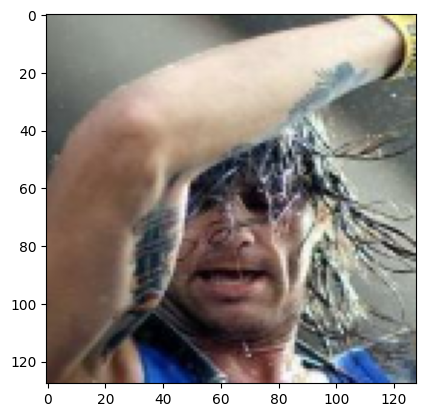

In [9]:
for batch in dataset.take(1):
    img = batch[0]
    plt.imshow((img+1)/2)
    break


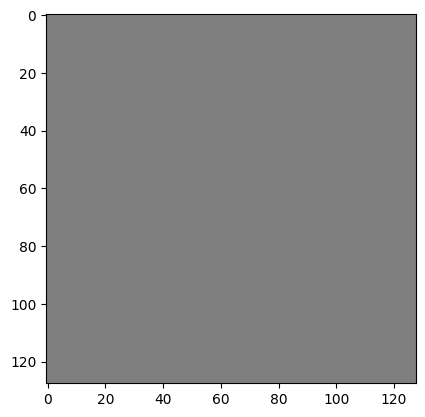

In [15]:

imgs = generator(tf.random.normal([4, z_dim]), training=False)
plt.imshow(((imgs[0] + 1)/2).numpy())

(-0.5, 127.5, 127.5, -0.5)

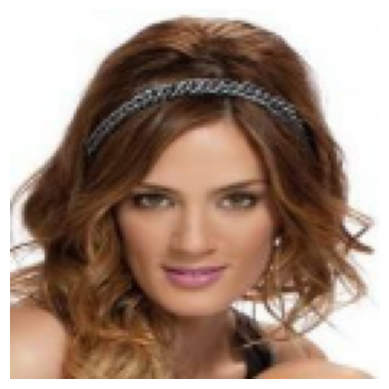

In [16]:
batch = next(iter(dataset))
plt.imshow(((batch[0] + 1) / 2).numpy())
plt.axis("off")

In [10]:
generator.summary()
for w in generator.weights[:10]:
    print(w.name, w.shape, tf.reduce_mean(w).numpy(), tf.reduce_min(w).numpy(), tf.reduce_max(w).numpy())
for w in generator.weights:
    print(w.name, w.dtype)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 4096)              409600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         2097152   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 512)         0 

In [11]:
#### wgan_gp = WGAN_GP(generator, critic, z_dim)
#wgan_gp = WGAN_GP(generator, critic, z_dim, gp_weight=10)
wgan_gp = WGAN_GP(generator, critic, z_dim=z_dim,
              n_critic=3, gp_weight=10.0)

#g_opt = tf.keras.optimizers.legacy.Adam(1e-4, beta_1=0.0, beta_2=0.9)
#c_opt = tf.keras.optimizers.legacy.Adam(1e-4, beta_1=0.0, beta_2=0.9)
"""
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.5,
    )
"""
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[2000, 6000, 12000],   # steps
    values=[1e-4, 5e-5, 2e-5, 1e-5]   # learning rates
)

clr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[6000, 9000, 12000],   # steps
    values=[1e-4, 5e-5, 2e-5, 1e-5]   # learning rates
)

glr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[6000, 8000, 10000, 12000],   # steps
    values=[2e-4, 1e-4, 5e-5, 2e-5, 2e-5]   # learning rates
)


g_opt = tf.keras.optimizers.legacy.Adam(glr_schedule, beta_1=0.0, beta_2=0.9)
c_opt = tf.keras.optimizers.legacy.Adam(clr_schedule, beta_1=0.0, beta_2=0.9)




wgan_gp.compile(g_optimizer=g_opt, c_optimizer=c_opt)
callbacks = [
    GenerateSamplesCallback(wgan_gp, z_dim=z_dim, out_dir="samples1", every_n_epochs=1)
]

history = wgan_gp.fit(dataset, epochs=30, steps_per_epoch=300, callbacks=callbacks)#)

Epoch 1/30
300/300 [==============================] - 619s 2s/step - critic_loss: -18.8299 - gen_loss: 24.8278
Epoch 2/30
300/300 [==============================] - 604s 2s/step - critic_loss: -21.5301 - gen_loss: 27.8324
Epoch 3/30
300/300 [==============================] - 602s 2s/step - critic_loss: -23.2418 - gen_loss: 30.2627
Epoch 4/30
300/300 [==============================] - 610s 2s/step - critic_loss: -23.8582 - gen_loss: 30.9858
Epoch 5/30
300/300 [==============================] - 606s 2s/step - critic_loss: -24.0370 - gen_loss: 32.1614
Epoch 6/30
300/300 [==============================] - 604s 2s/step - critic_loss: -24.0204 - gen_loss: 30.4888
Epoch 7/30
300/300 [==============================] - 602s 2s/step - critic_loss: -23.7568 - gen_loss: 31.1958
Epoch 8/30
300/300 [==============================] - 603s 2s/step - critic_loss: -13.6068 - gen_loss: 15.8889
Epoch 9/30
300/300 [==============================] - 604s 2s/step - critic_loss: -14.5617 - gen_loss: 16.8266
E

In [ ]:
wgan_gp = WGAN_GP(generator, critic, z_dim=z_dim,
              n_critic=5, gp_weight=10.0)
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[2000, 6000, 12000],   # steps
    values=[1e-4, 5e-5, 2e-5, 1e-5]   # learning rates
)

clr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[6000, 9000, 12000],   # steps
    values=[1e-4, 5e-5, 2e-5, 1e-5]   # learning rates
)

glr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[6000, 8000, 10000, 12000],   # steps
    values=[2e-4, 1e-4, 5e-5, 2e-5, 2e-5]   # learning rates
)

g_opt = tf.keras.optimizers.legacy.Adam(glr_schedule, beta_1=0.0, beta_2=0.9)
c_opt = tf.keras.optimizers.legacy.Adam(clr_schedule, beta_1=0.0, beta_2=0.9)


wgan_gp.compile(g_optimizer=g_opt, c_optimizer=c_opt)
callbacks = [
    GenerateSamplesCallback(wgan_gp, z_dim=z_dim, out_dir="samples2", every_n_epochs=1)
]

history = wgan_gp.fit(dataset, epochs=20, steps_per_epoch=300, callbacks=callbacks)#)

wgan_gp = WGAN_GP(generator, critic, z_dim=z_dim,
              n_critic=3, gp_weight=10.0)
plt.plot(history.history["critic_loss"], label="Critic Loss")
plt.plot(history.history["gen_loss"], label="Generator Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()
#4 * 4 * 512 

In [ ]:

wgan_gp = WGAN_GP(generator, critic, z_dim=z_dim,
              n_critic=4, gp_weight=10.0)
wgan_gp.compile(g_optimizer=g_opt, c_optimizer=c_opt)
callbacks = [
    GenerateSamplesCallback(wgan_gp, z_dim=z_dim, out_dir="samples", every_n_epochs=1)
]
plt.plot(history.history["critic_loss"], label="Critic Loss")
plt.plot(history.history["gen_loss"], label="Generator Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
generator.save("generator128X128 64 to 1024epoch n_cri3 decay2.keras")
critic.save("critic128X128 64epoch 64 to 1024  n_cri3 decay2.keras")

In [ ]:
   """
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        #epsilon = 1e-3
        for _ in range(self.n_critic):
            z = tf.random.normal([batch_size, self.z_dim])
            with tf.GradientTape() as tape:
                fake_images = self.generator(z, training=True)
                real_output = self.critic(real_images, training=True)
                fake_output = self.critic(fake_images, training=True)
                gp = gradient_penalty(self.critic, real_images, fake_images)
                critic_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + self.gp_weight * gp
                
                #critic_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) \
              #+ self.gp_weight * gp \
              #+ epsilon * tf.reduce_mean(tf.square(real_output))
            grads = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Generator update
        z = tf.random.normal([batch_size, self.z_dim])
        with tf.GradientTape() as tape:
            fake_images = self.generator(z, training=True)
            fake_output = self.critic(fake_images, training=True)
            gen_loss = -tf.reduce_mean(fake_output)
        grads = tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {"critic_loss": critic_loss, "gen_loss": gen_loss}
     """

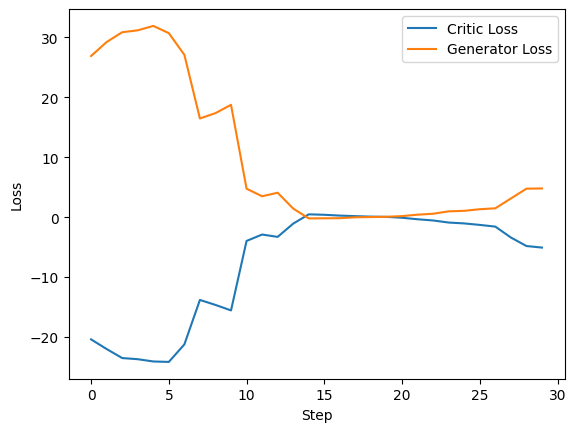

In [12]:
plt.plot(history.history["critic_loss"], label="Critic Loss")
plt.plot(history.history["gen_loss"], label="Generator Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()
####4 * 4 * 256 128X128 30epoch batch 64 

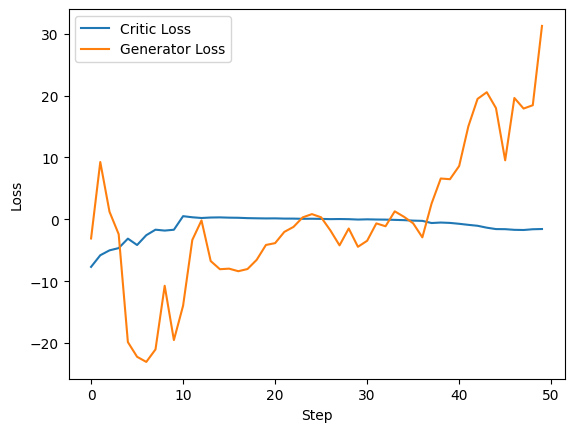

In [13]:

####4 * 4 * 256 128 X 128 50 epoch batch 64

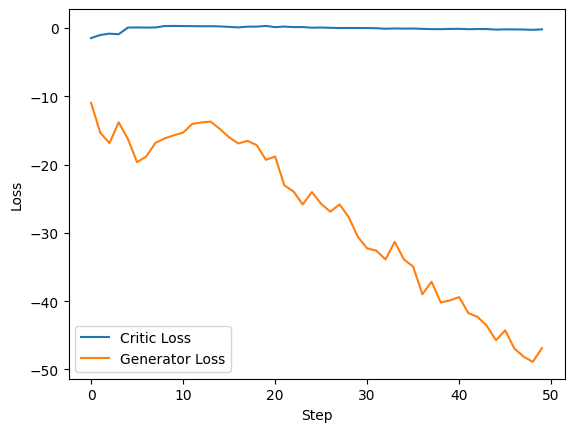

In [13]:



####4 * 4 * 256 64 X 64 50 epoch batch 64

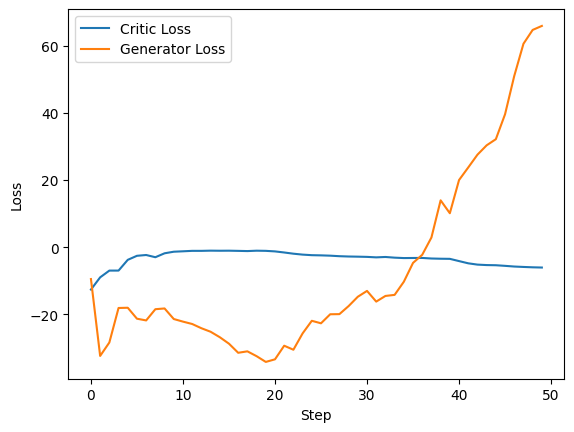

In [14]:

####4 * 4 * 256 128 X 128 50 epoch batch 64

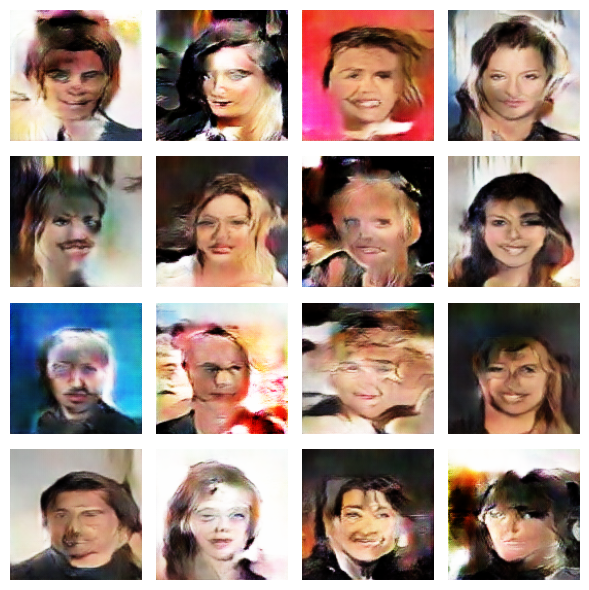

In [16]:
plot_images(wgan_gp.generator, z_dim)
####4 * 4 * 256 128X128 30epoch batch 64 

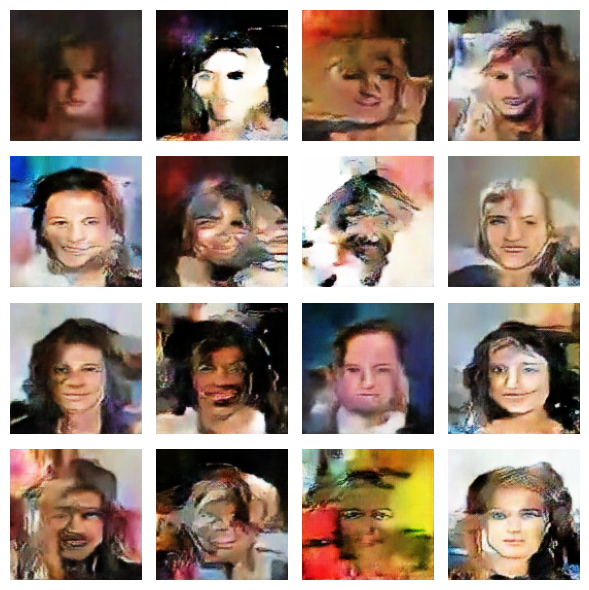

In [16]:
plot_images(wgan_gp.generator, z_dim)
####4 * 4 * 256 128 X 128 50 epoch batch 64

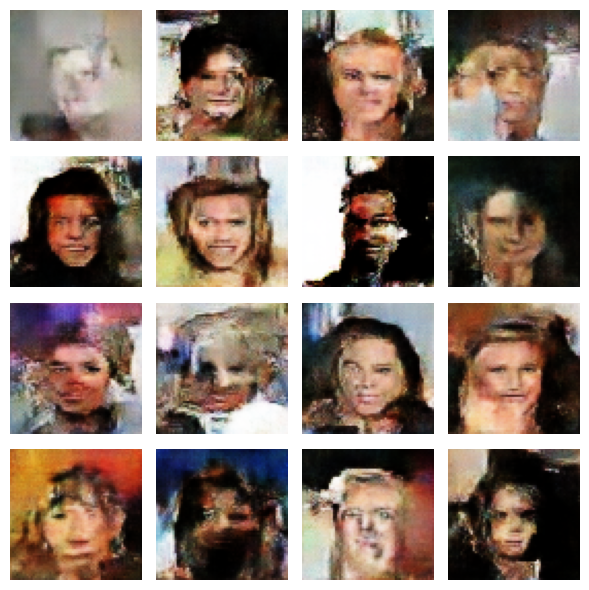

In [15]:
plot_images(wgan_gp.generator, z_dim)
####4 * 4 * 256 64 X 64 50 epoch batch 64

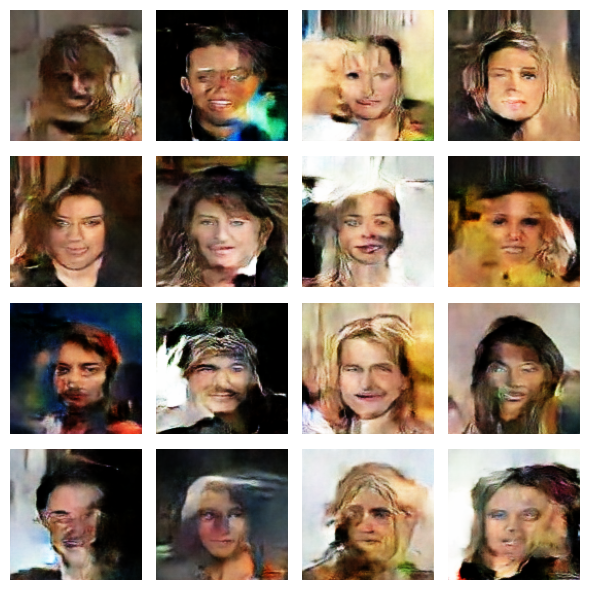

In [16]:
plot_images(wgan_gp.generator, z_dim)
####4 * 4 * 256 128 X 128 50 epoch batch 64

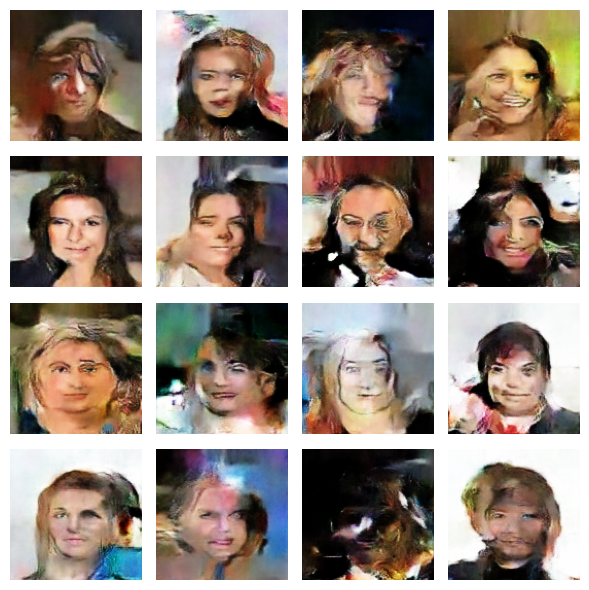

In [20]:
plot_images(wgan_gp.generator, z_dim)
####4 * 4 * 512 128 X 128 50 epoch batch 128

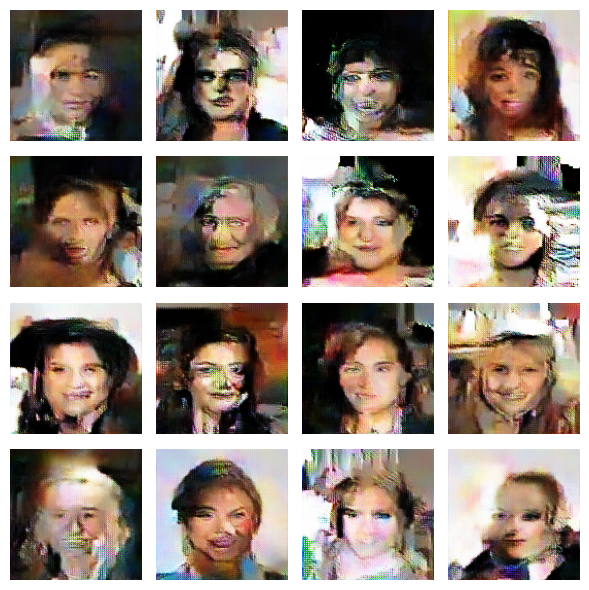

In [37]:

####4 * 4 * 1024 128X128 50 epoch batch 64

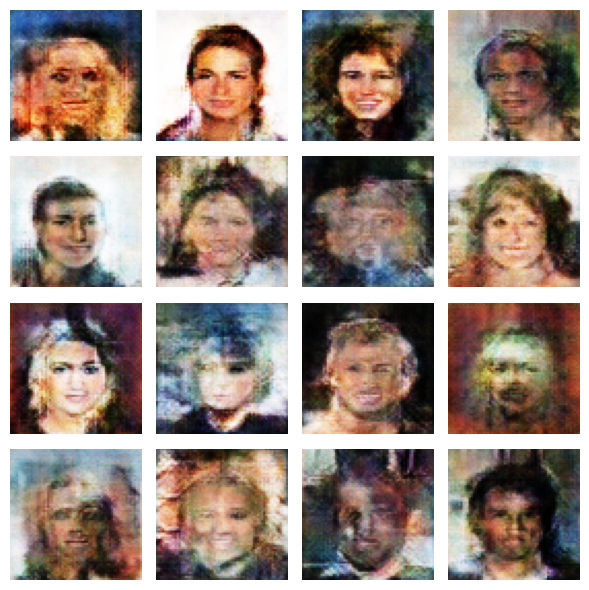

In [22]:
####4*4*512 64 X 64 50 epoch batch 64

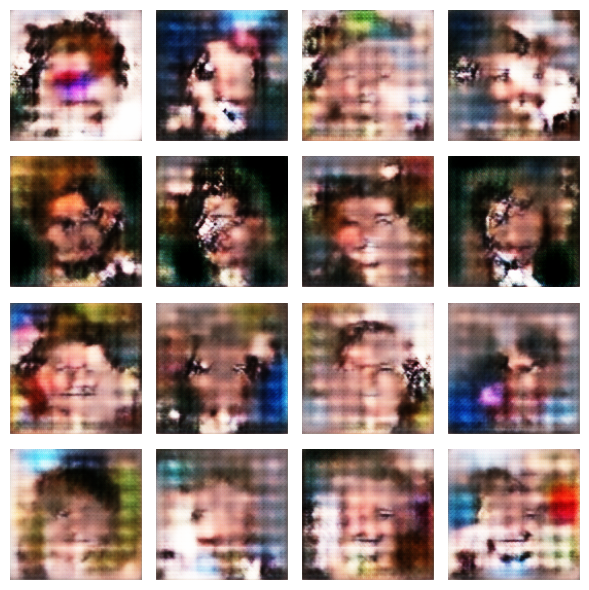

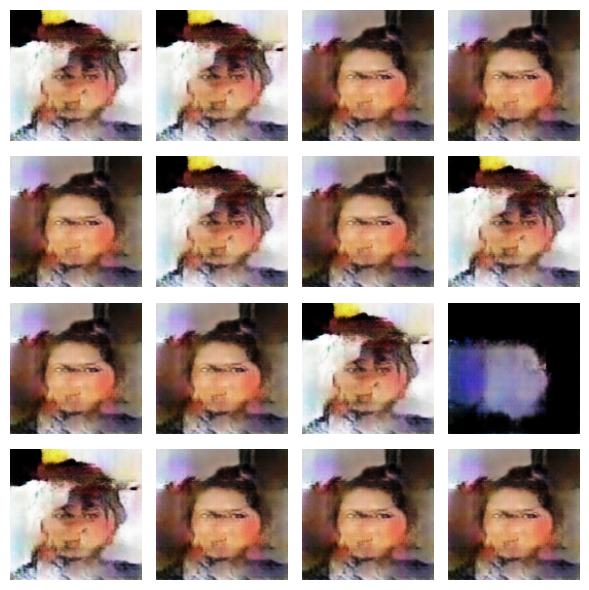

In [24]:
!pip install imageio

In [38]:
import imageio
import os

def create_gif_from_png(folder_path, output_path="output.gif", duration=0.15):
    # duration = seconds per frame
    png_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith(".png")]
    )

    images = []
    for file in png_files:
        img_path = os.path.join(folder_path, file)
        images.append(imageio.imread(img_path))

    imageio.mimsave(output_path, images, duration=duration)
    print(f"GIF saved at: {output_path}")

In [39]:
create_gif_from_png("samples", "128X128 1.gif", duration=0.2)

/var/folders/8h/f5km4mgs57zcz652_p9mp8jw0000gn/T/ipykernel_24420/2682726268.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_path))


GIF saved at: 128X128 1.gif


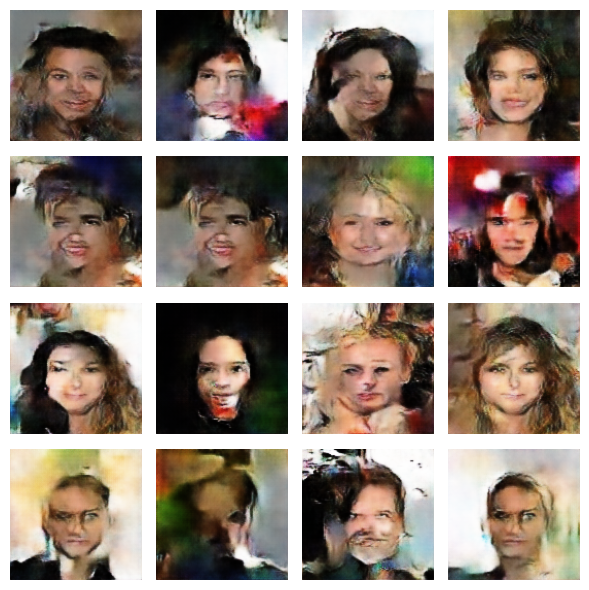